## DreamBooth on Stable Diffusion 2.1

DreamBooth is a powerful technique for personalizing latent diffusion models, such as Stable Diffusion, allowing the model to be fine-tuned to generate specific images based on a limited set of data.

### Step 0: Environment configuration

This command installs the "diffusers" library directly from the Hugging Face GitHub repository.The diffusers library is used to work with latent diffusion models, such as Stable Diffusion, and provides tools for image generation, fine-tuning, and other functionalities.


In [1]:
!pip install -r ../requirements.txt --quiet

### Configuration and Secrets Loading
In this section, we load configuration parameters and API keys from separate YAML files. This separation helps maintain security by keeping sensitive information (API keys) separate from configuration settings.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs
- **secrets.yaml**: Contains sensitive API keys for services like Galileo and HuggingFace


In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from src.utils import (
    load_config_and_secrets,
    configure_proxy,
    setup_galileo_environment,
)

from core.custom_metrics.image_metrics_scorers import entropy_scorer, complexity_scorer, set_custom_image_path
from core.deploy.deploy_image_generation import deploy_model
from core.local_inference.inference import StableDiffusionPipelineOutput, load_config, run_inference
from core.dreambooth_inference.inference_dreambooth import StableDiffusionPipelineOutput, load_config_dreambooth, run_inference_dreambooth



from huggingface_hub import snapshot_download
import promptquality as pq
import glob

2025-05-15 06:49:23.264694: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 06:49:23.298982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747291763.320635    1244 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747291763.327349    1244 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747291763.344947    1244 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [6]:
CONFIG_PATH = "../../configs/config.yaml"
SECRETS_PATH = "../../configs/secrets.yaml"

config, secrets = load_config_and_secrets(CONFIG_PATH, SECRETS_PATH)

In [7]:
configure_proxy(config)

### Download model local

This code imports the snapshot_download function from the huggingface_hub library to download the latest version of the "stabilityai/stable-diffusion-2-1" model. It sets a local directory for saving the model (local_model_path), and the download is configured to be resumable in case it is interrupted, with an etag timeout set to 60 seconds.

In [5]:
# Download the snapshot directly to the local directory
local_model_path = os.path.join("..", "..", "..", "local", "stable-diffusion-2-1")

# Downloading the latest revision of the "stabilityai/stable-diffusion-2-1" model
snapshot_download(
    repo_id="stabilityai/stable-diffusion-2-1", 
    local_dir=local_model_path,
    resume_download=True,
    etag_timeout=60  
)

/opt/conda/lib/python3.12/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

v2-1_768-ema-pruned.ckpt:   0%|          | 0.00/5.21G [00:00<?, ?B/s]

v2-1_768-ema-pruned.safetensors:   0%|          | 0.00/5.21G [00:00<?, ?B/s]

v2-1_768-nonema-pruned.ckpt:   0%|          | 0.00/5.21G [00:00<?, ?B/s]

(…)1272ce639e1032b0a1f0f6586347feb953c244f4:   0%|          | 0.00/5.21G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

'/home/jovyan/local/stable-diffusion-2-1'

### Step 1: Load the Model
We load the pre-trained Stable Diffusion 2.1 model from Hugging Face and move it to the GPU for efficient execution

Detected 2 GPUs, using config/default_config_multi-gpu.yaml
GPU 0: 45GB of available memory.
GPU 1: 45GB of available memory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Taking `'Attention' object has no attribute 'key'` while using `accelerate.load_checkpoint_and_dispatch` to mean ../../../local/stable-diffusion-2-1/vae was saved with deprecated attention block weight names. We will load it with the deprecated attention block names and convert them on the fly to the new attention block format. Please re-save the model after this conversion, so we don't have to do the on the fly renaming in the future. If the model is from a hub checkpoint, please also re-upload it or open a PR on the original repository.


  0%|          | 0/60 [00:00<?, ?it/s]

Average Inference Time: 12.54 seconds
Median Inference Time: 12.54 seconds
Min Inference Time: 12.54 seconds
Max Inference Time: 12.54 seconds


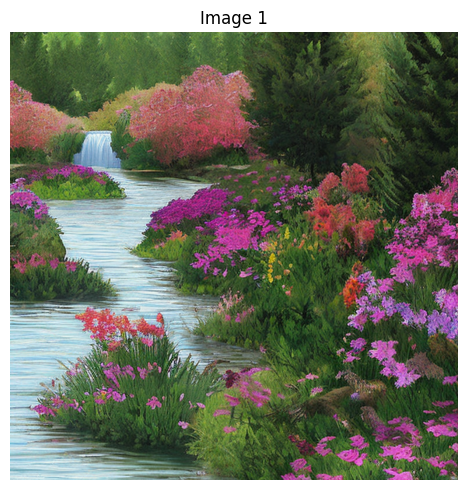

In [6]:
config = load_config()

run_inference(
    prompt="A beautiful landscape",
    height=768,
    width=768,
    num_images=1,
    num_inference_steps=60,
    output=True  
)



## Step 3: DreamBooth Training

This Bash script uses PyTorch to detect the number of available GPUs, automatically selects either the multi-GPU or single-GPU configuration file, and then launches the DreamBooth training process on Stable Diffusion via `accelerate launch` with your specified parameters. It also captures the start and end timestamps to calculate the total training duration.

> **Tip:** To enable full, verbose logging, add the `--log_level=DEBUG` flag to your command.


In [3]:
%%bash
NUM_GPUS=$(python3 -c "import torch; print(torch.cuda.device_count())")

if [ "$NUM_GPUS" -ge 2 ]; then
  CONFIG_FILE="config/default_config_multi-gpu.yaml"
  echo "Detected $NUM_GPUS GPUs, using $CONFIG_FILE"
else
  CONFIG_FILE="config/default_config_one-gpu.yaml"
  echo "Detected $NUM_GPUS GPU, using $CONFIG_FILE"
fi

START=$(date +%s)

accelerate launch --config_file $CONFIG_FILE core/train/train_dreambooth_aistudio.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1"  \
  --log_level=ERROR \
  --instance_data_dir="../data/img" \
  --output_dir="./dreambooth/" \
  --instance_prompt="A modern laptop on a sandy beach with the ocean in the background, sunlight reflecting off the screen" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=400 \
  --logging_dir="/phoenix/tensorboard/tensorlogs" \
  --report_to="tensorboard" \
  --validation_prompt="A photo of an HP laptop on the sand with a sunset over the ocean in the background." \
  --num_validation_images=1 \
  --validation_steps=100

END=$(date +%s)
DIFF=$(( $END - $START ))


Detected 2 GPUs, using config/default_config_multi-gpu.yaml
[2025-05-15 06:50:46,218] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


df: /home/jovyan/.triton/autotune: No such file or directory
2025-05-15 06:50:55.668920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 06:50:55.686487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747291855.709070    1433 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747291855.721241    1433 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747291855.741515    1433 computation_placer.cc:177] computation place

[2025-05-15 06:51:18,039] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-05-15 06:51:18,078] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-05-15 06:51:19,191] [INFO] [comm.py:652:init_distributed] cdb=None
[2025-05-15 06:51:19,356] [INFO] [comm.py:652:init_distributed] cdb=None
[2025-05-15 06:51:19,356] [INFO] [comm.py:683:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'thresholding', 'sample_max_value', 'clip_sample_range', 'timestep_spacing', 'variance_type', 'dynamic_thresholding_ratio', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.
{'shift_factor', 'mid_block_add_attention', 'latents_std', 'force_upcast', 'use_post_quant_conv', 'use_quant_conv', 'latents_mean', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'encoder_hid_dim_type', 'mid_block_only_cross_attention', 'conv_out_kernel', 'class_embeddings_concat', 'time_embedding_type', 'attention_type', 'addition_embed_type', 'dropout', 'resnet_out_scale_factor', 'addition_time_embed_dim', 'conv_in_kernel', 'addition_embed_type_num_heads', 'reverse_transformer_layers_per_block', 'transformer_layers_per_block', 'projection_class_embeddings_input_dim', 'ti

[2025-05-15 06:52:29,112] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.15.1, git-hash=unknown, git-branch=unknown
[2025-05-15 06:52:29,112] [INFO] [config.py:733:__init__] Config mesh_device None world_size = 2
[2025-05-15 06:52:29,112] [INFO] [config.py:733:__init__] Config mesh_device None world_size = 2
[2025-05-15 06:52:32,198] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2025-05-15 06:52:32,200] [INFO] [logging.py:96:log_dist] [Rank 0] Using client Optimizer as basic optimizer
[2025-05-15 06:52:32,200] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2025-05-15 06:52:32,268] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = AdamW
[2025-05-15 06:52:32,268] [INFO] [utils.py:59:is_zero_supported_optimizer] Checking ZeRO support for optimizer=AdamW type=<class 'torch.optim.adamw.AdamW'>
[2025-05-15 06:52:32,269] [INFO] [logging.py:96:log_dist] [Rank 0

Fetching 3 files: 100%|���█████████| 3/3 [00:00<00:00, 17.56it/s]A
{'image_encoder'} was not found in config. Values will be initialized to default values.

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]{'thresholding', 'sample_max_value', 'clip_sample_range', 'timestep_spacing', 'dynamic_thresholding_ratio', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.
Loaded scheduler as DDIMScheduler from `scheduler` subfolder of stabilityai/stable-diffusion-2-1.

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 18.07it/s]
{'thresholding', 'sample_max_value', 'clip_sample_range', 'timestep_spacing', 'variance_type', 'dynamic_thresholding_ratio', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.
Steps:  50%|█████     | 200/400 [05:38<05:23,  1.62s/it, loss=0.106, lr=5e-6]{'image_encoder'} was not found in config. Values will be initialized to default values.

Loa

## Inference Local Model

This code imports functions from the inference_dreambooth module, loads a configuration, and then runs inference to generate images. It uses a prompt to create three images with a resolution of 768x768 pixels, executing 100 inference steps per image.

Detected 2 GPUs, using config/default_config_multi-gpu.yaml
GPU 0: 45GB of available memory.
GPU 1: 45GB of available memory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Average Inference Time: 17.26 seconds
Median Inference Time: 13.99 seconds
Min Inference Time: 13.73 seconds
Max Inference Time: 24.08 seconds


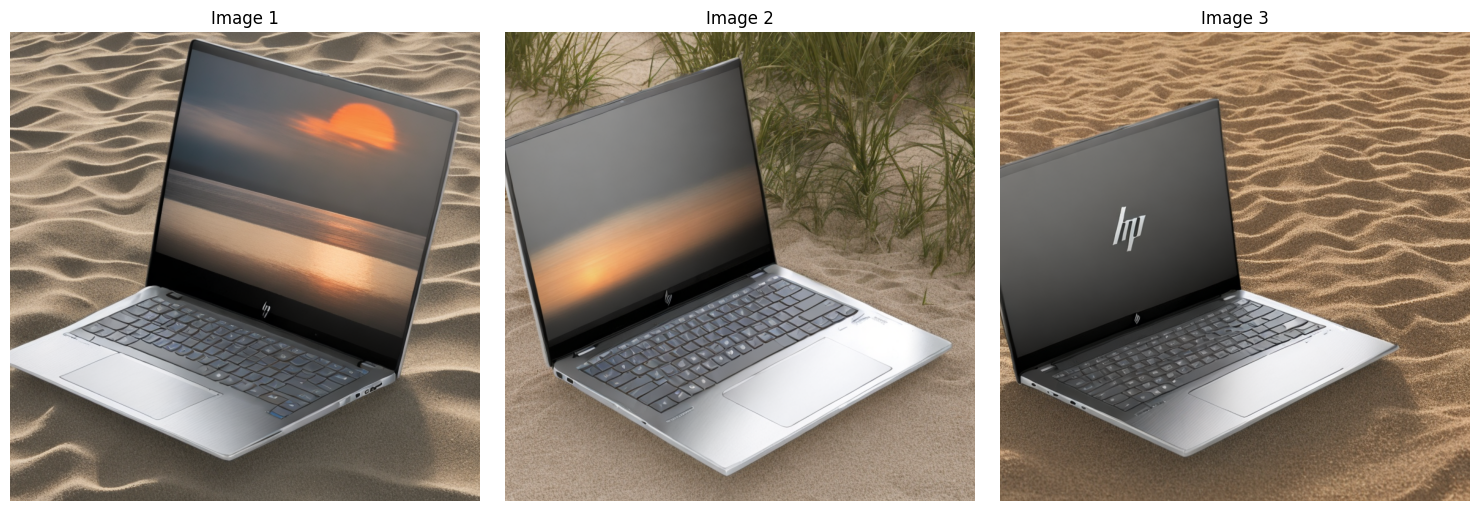

In [4]:
config = load_config_dreambooth()

run_inference_dreambooth(
    prompt="A high-quality photo of an HP laptop placed on the sand at the beach, with a sunset over the ocean in the background.", 
    height=768, 
    width=768, 
    num_images=3, 
    num_inference_steps=100,
    output=True
)


## Galileo Evaluate Custom metrics
Galileo GenAI Studio supports Custom Metrics (programmatic or GPT-based) for all your Evaluate and Observe projects. 

In [8]:
#########################################
# In order to connect to Galileo, create a secrets.yaml file in the configs folder.
# This file should be an entry called GALILEO_API_KEY, with your personal Galileo API Key
# Galileo API keys can be created on https://console.hp.galileocloud.io/settings/api-keys
#########################################

setup_galileo_environment(secrets)
pq.login(os.environ['GALILEO_CONSOLE_URL'])

👋 You have logged into 🔭 Galileo (https://console.hp.galileocloud.io/) as diogo.vieira@hp.com.


Config(console_url=HttpUrl('https://console.hp.galileocloud.io/'), username=None, password=None, api_key=SecretStr('**********'), token=SecretStr('**********'), current_user='diogo.vieira@hp.com', current_project_id=None, current_project_name=None, current_run_id=None, current_run_name=None, current_run_url=None, current_run_task_type=None, current_template_id=None, current_template_name=None, current_template_version_id=None, current_template_version=None, current_template=None, current_dataset_id=None, current_job_id=None, current_prompt_optimization_job_id=None, api_url=HttpUrl('https://api.hp.galileocloud.io/'))

In [9]:

#########################################

# Returns the path of the most recent image that matches the specified pattern.

#########################################

def get_latest_generated_image(directory: str = "./", prefix: str = "local_model_result_", ext: str = ".png") -> str:
    files = glob.glob(os.path.join(directory, f"{prefix}*{ext}"))
    if not files:
        raise FileNotFoundError("No generated images found.")
    latest_file = max(files, key=os.path.getmtime)
    return latest_file

Detected 2 GPUs, using config/default_config_multi-gpu.yaml
GPU 0: 45GB of available memory.
GPU 1: 45GB of available memory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Average Inference Time: 13.83 seconds
Median Inference Time: 13.83 seconds
Min Inference Time: 13.83 seconds
Max Inference Time: 13.83 seconds


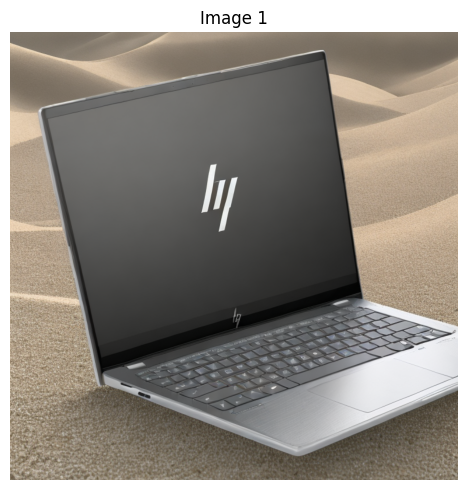

[set_custom_image_path] CUSTOM_IMAGE_PATH: ./local_model_result_0.png


Generating responses with openai...:   0%|          | 0/8 [00:00<?, ?it/s]

Initial job complete, executing scorers asynchronously. Current status:
cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
latency: Done ✅
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/2d54dddd-38f9-4a86-8971-3c19606eae20/4b7ad292-0025-4b6c-aab8-1c0a4918029d?taskType=7
[executor_entropy] Using image_path: ./local_model_result_0.png
[load_image] Loading the image of: ./local_model_result_0.png
[load_image] Image loaded with shape: (768, 768, 3), dtype: float32
[convert_to_grayscale] Image converted to grayscale. Shape: (768, 768)
[shannon_entropy_np] Entropia calculada: -118.52680287561361
[executor_entropy] Entropy: -118.52680287561361
[executor_complexity] Using image_path: ./local_model_result_0.png
[load_image] Loading the image of: ./local_model_result_0.png
[load_image] Image loaded with shape: (768, 768, 3), dtype: float32
[convert_to_grayscale] Image converted to grayscale. Shape: (768, 768)
[calculate_complexity] Compl

In [10]:

config = load_config_dreambooth()

prompt_text = ("A high-quality photo of an HP laptop placed on the sand at the beach, "
               "with a sunset over the ocean in the background.")

run_inference_dreambooth(
    prompt=prompt_text, 
    height=768, 
    width=768, 
    num_images=1, 
    num_inference_steps=100,
    output=True
)

generated_image_path = get_latest_generated_image()

set_custom_image_path(generated_image_path)

template = prompt_text

result_custom = pq.run(template=template, scorers=[entropy_scorer, complexity_scorer])
print("Result:", result_custom)

## Model Service

Using MLflow, we will save and load the model in an integrated manner, enabling the traceability and reproducibility of experiments. MLflow will facilitate model versioning, monitoring, and deployment, ensuring a robust pipeline for your project.

In [11]:
deploy_model()

2025-05-15 07:08:37,537 — INFO — Using accelerate cfg: config/default_config_multi-gpu.yaml
2025/05/15 07:08:37 INFO mlflow.tracking.fluent: Experiment with name 'ImageGeneration' does not exist. Creating a new experiment.
2025/05/15 07:08:38 INFO mlflow.models.signature: Inferring model signature from type hints
/opt/conda/lib/python3.12/site-packages/mlflow/pyfunc/__init__.py:3139: UserWarning: Failed to infer signature from type hint: Type hints must be wrapped in list[...] because MLflow assumes the predict method to take multiple input instances. Specify your type hint as `list[typing.Union[pandas.core.frame.DataFrame, dict]]` for a valid signature.
  signature_from_type_hints = _infer_signature_from_type_hints(
/opt/conda/lib/python3.12/site-packages/mlflow/pyfunc/__init__.py:3212: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/model

2025-05-15 07:26:39,870 — INFO — ✅ Model logged to MLflow at «image_generation_model»
Successfully registered model 'ImageGenerationService'.
Created version '1' of model 'ImageGenerationService'.
2025-05-15 07:26:40,287 — INFO — 🏷️ Registered «ImageGenerationService» (run d20f7e9a97274028ba1dc64682acbc44)
